<a href="https://colab.research.google.com/github/Eddy-Emmanuel/Bank-Note-Authentication/blob/main/Predicting_Compressive_Strength_Of_Concrete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORT LIBRARIES

In [1]:
!pip install optuna
!pip install xgboost

In [2]:
from warnings import filterwarnings
filterwarnings(action="ignore")

import numpy as np
import pandas as pd

import tabulate
from io import StringIO

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from functools import partial
from optuna import create_study
from xgboost import XGBRegressor

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("/content/concrete.csv")
print(f"Shape: {df.shape}")
df.head()

Shape: (1030, 9)


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [4]:
info_display = StringIO()
df.info(buf=info_display)
print(info_display.getvalue())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB



In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


In [6]:
df.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

## EDA

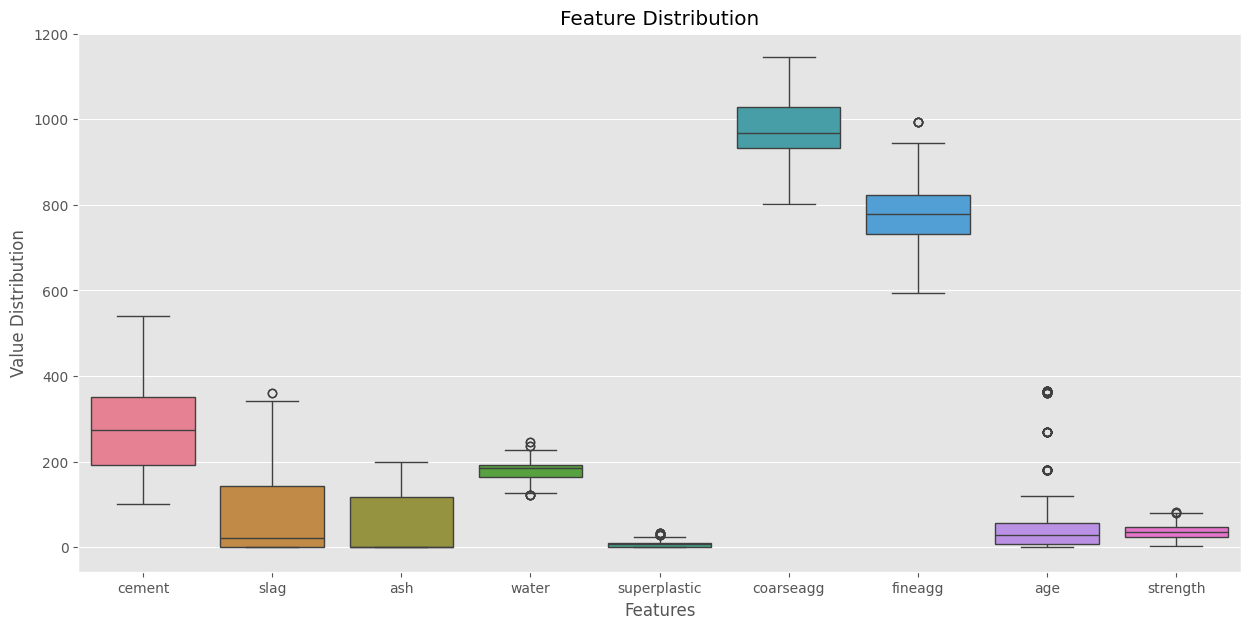

In [7]:
plt.figure(figsize=(15, 7))
sns.boxplot(df)
plt.xlabel("Features")
plt.ylabel("Value Distribution")
plt.title("Feature Distribution")
plt.show()

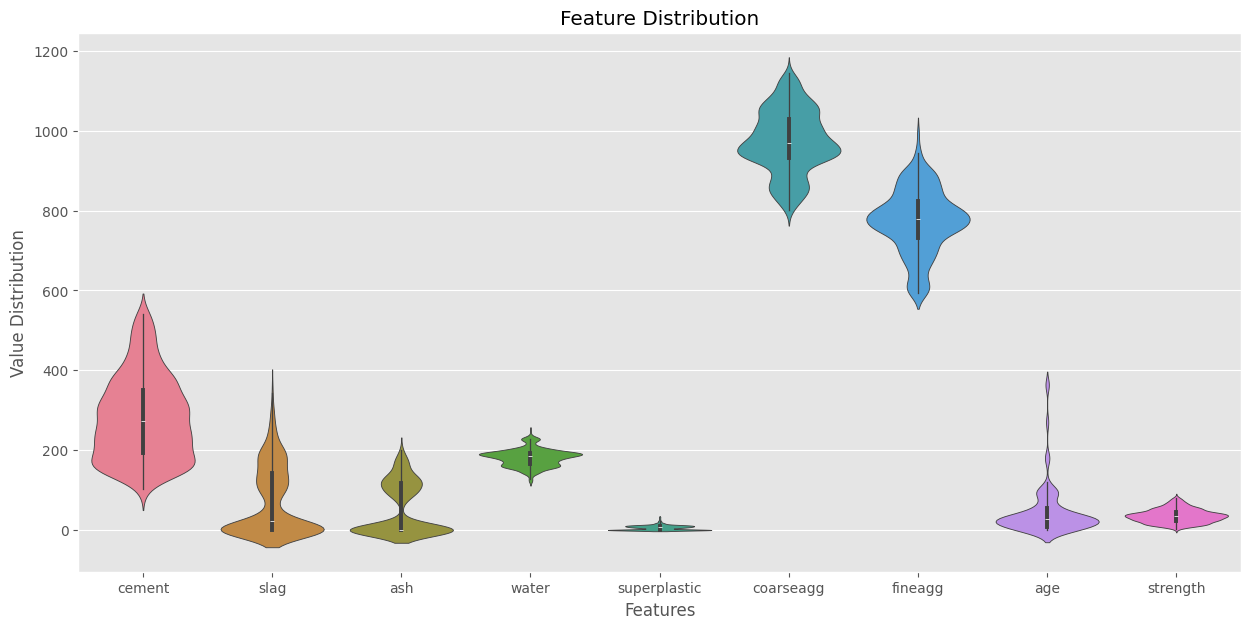

In [8]:
plt.figure(figsize=(15, 7))
sns.violinplot(df)
plt.xlabel("Features")
plt.ylabel("Value Distribution")
plt.title("Feature Distribution")
plt.show()

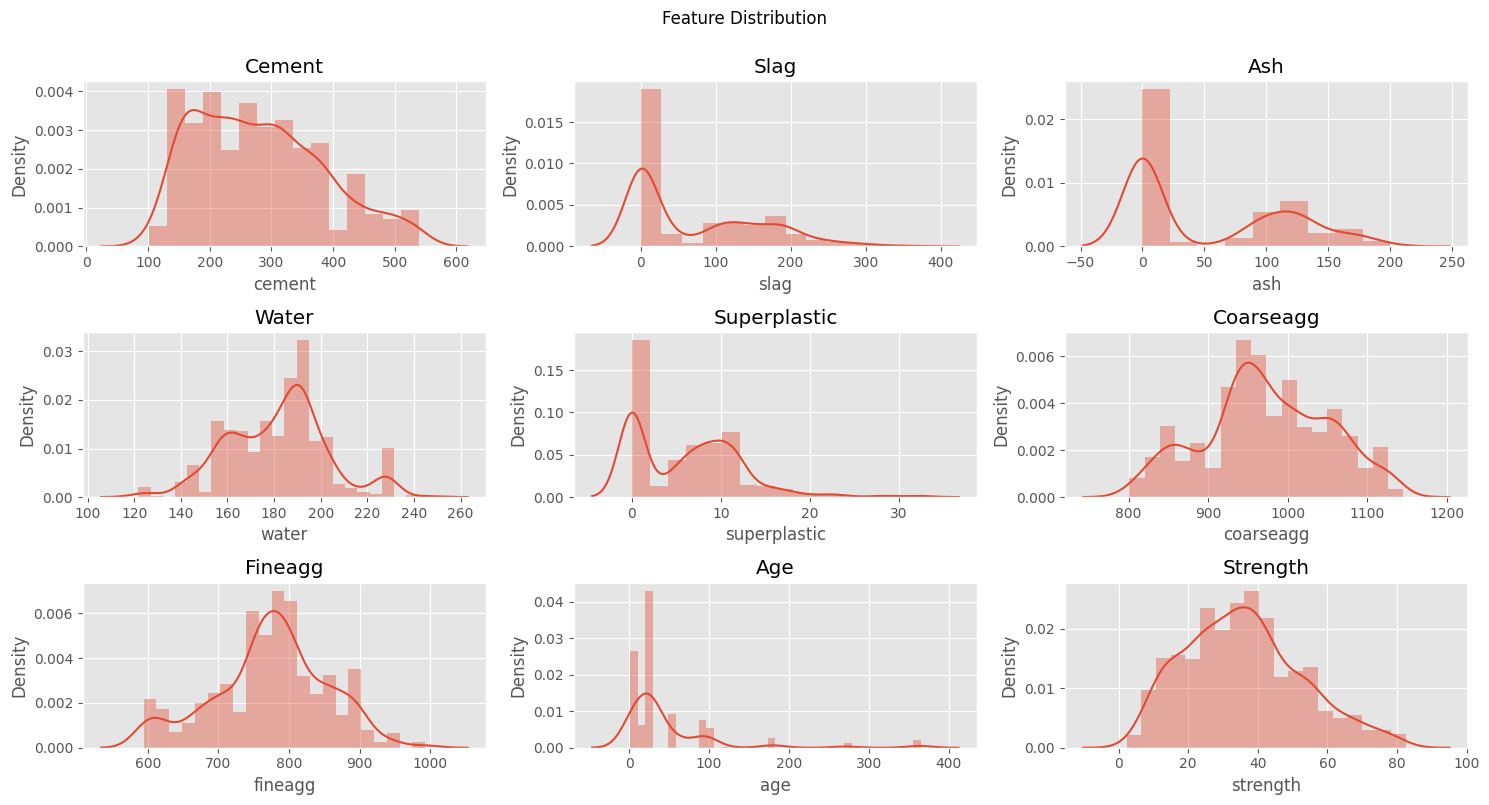

In [9]:
plt.figure(figsize=(15, 8))
for idx, col in enumerate(df.columns, start=1):
    plt.subplot(int(f"33{idx}"))
    sns.distplot(df[col])
    plt.title(col.title())

plt.suptitle("Feature Distribution", y=1)
plt.tight_layout()
plt.show()

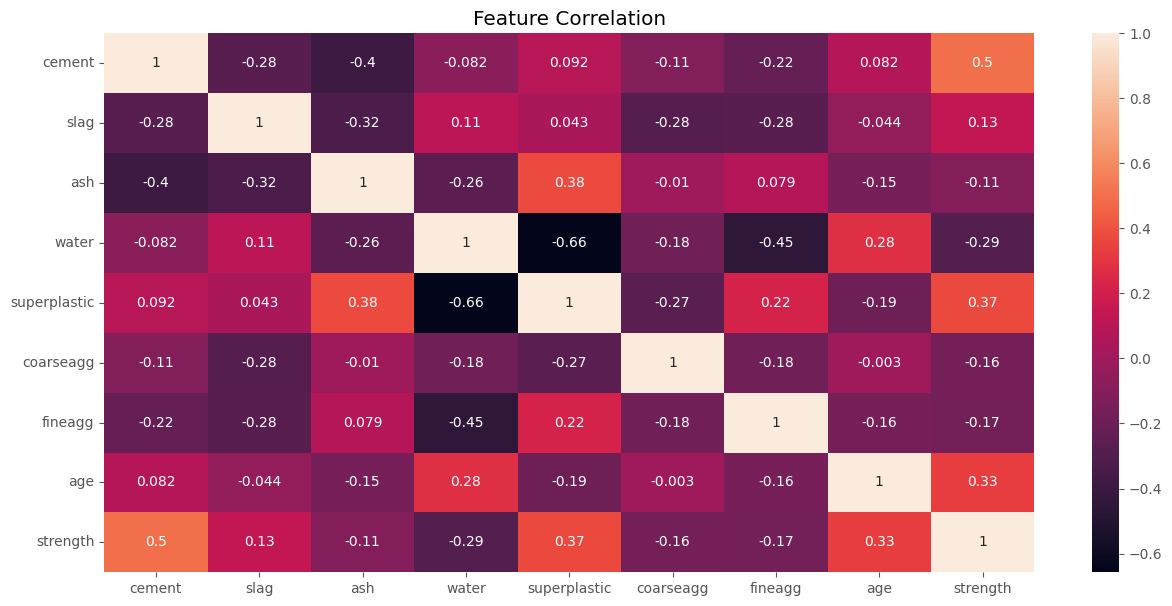

In [10]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True)
plt.title("Feature Correlation")
plt.show()

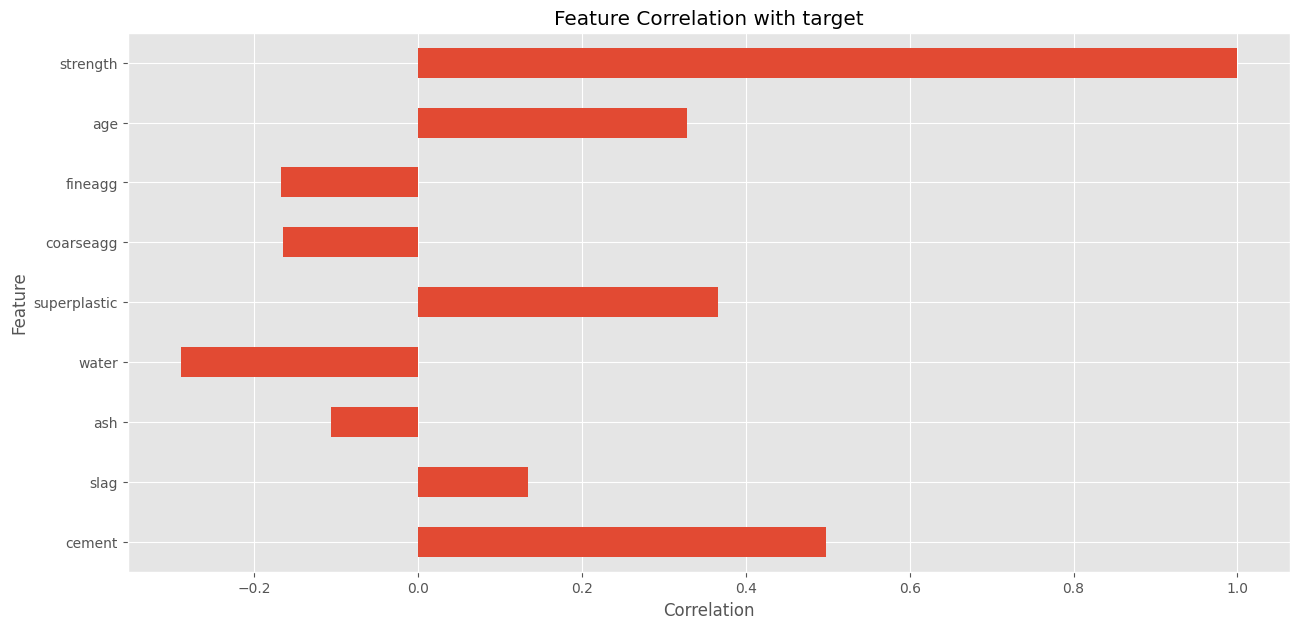

In [11]:
df.corr()["strength"].plot(kind="barh",
                           title="Feature Correlation with target",
                           figsize=(15, 7),
                           xlabel="Correlation",
                           ylabel="Feature")
plt.show()

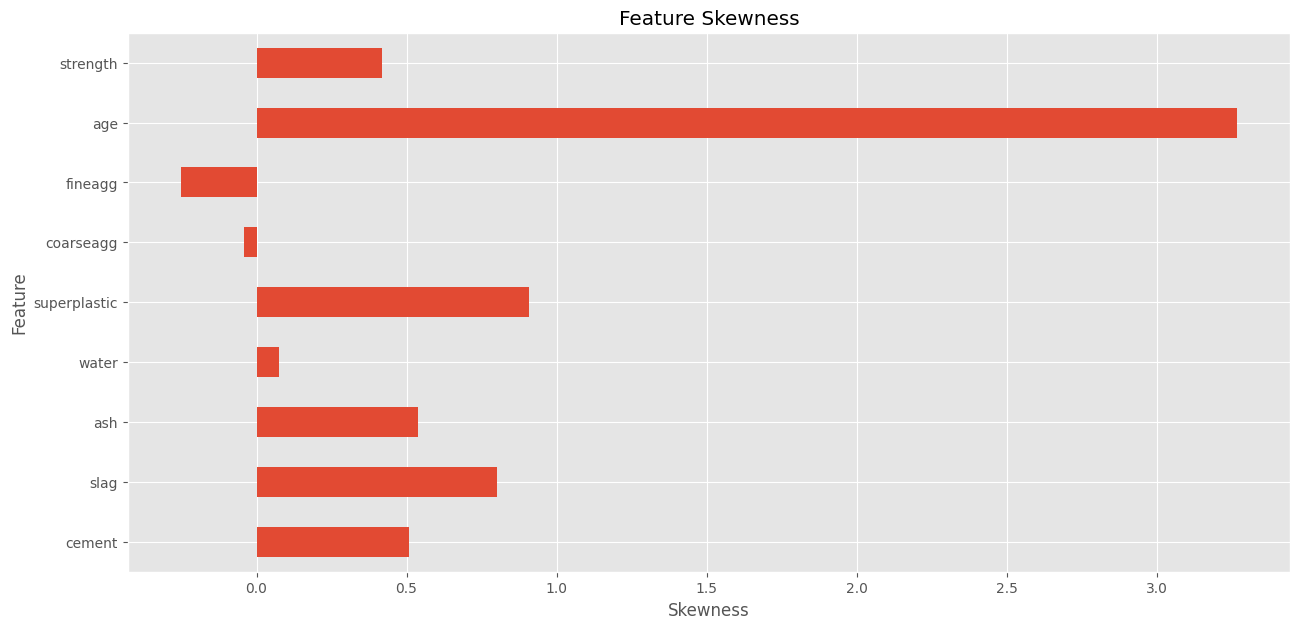

In [12]:
df.skew().plot(kind="barh",
               title="Feature Skewness",
               figsize=(15, 7),
               xlabel="Skewness",
               ylabel="Feature")
plt.show()

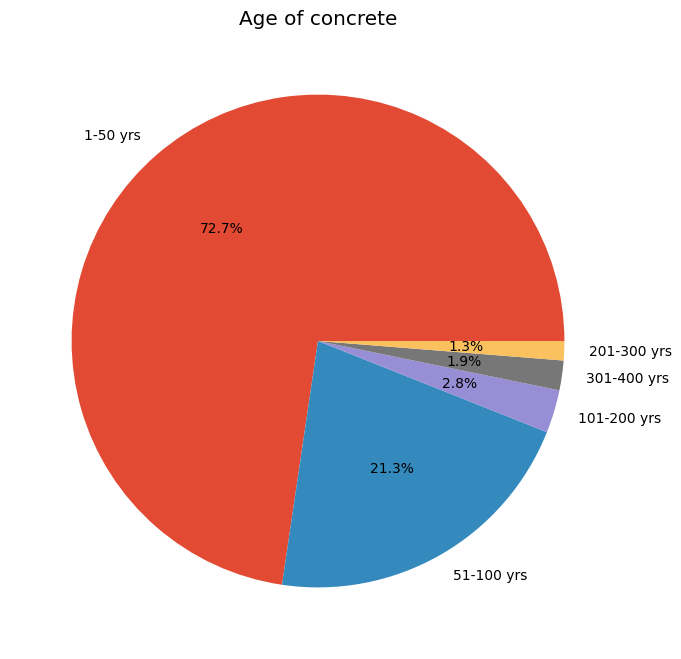

In [13]:
age_bins = pd.cut(df["age"],
                  bins=[1, 50, 100, 200, 300, 400],
                  labels=["1-50 yrs", "51-100 yrs", "101-200 yrs", "201-300 yrs", "301-400 yrs"])

plt.figure(figsize=(15, 8))
plt.pie(age_bins.value_counts(),
        labels=age_bins.value_counts().index,
        autopct="%1.1f%%")

plt.title("Age of concrete")

plt.show()

## PREPROCESSING

In [14]:
X = pd.DataFrame(StandardScaler().fit_transform(df.drop("strength", axis=1)),
                 columns=df.drop("strength", axis=1).columns)
y = df["strength"]

## TRAIN-TEST-SPLIT

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=0)

## MODELLING

#### XGBRegressor

In [16]:
xgb_model = XGBRegressor()

In [17]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## FEATURE IMPORTANCE

In [18]:
print(f"MAE: {metrics.mean_absolute_error(xgb_model.predict(X_test), y_test)}")
print(f"MSE: {metrics.mean_squared_error(xgb_model.predict(X_test), y_test)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(xgb_model.predict(X_test), y_test))}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(xgb_model.predict(X_test), y_test)}")
print(f"R2 SCORE: {metrics.r2_score(xgb_model.predict(X_test), y_test)}")

MAE: 3.026212417639575
MSE: 30.446444151461563
RMSE: 5.517829659518457
MAPE: 0.10264878527529633
R2 SCORE: 0.8747409318412404


In [19]:
print(f"MAE: {metrics.mean_absolute_error(xgb_model.predict(X_test), y_test)}")
print(f"MSE: {metrics.mean_squared_error(xgb_model.predict(X_test), y_test)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(xgb_model.predict(X_test), y_test))}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(xgb_model.predict(X_test), y_test)}")
print(f"R2 SCORE: {metrics.r2_score(xgb_model.predict(X_test), y_test)}")

MAE: 3.026212417639575
MSE: 30.446444151461563
RMSE: 5.517829659518457
MAPE: 0.10264878527529633
R2 SCORE: 0.8747409318412404


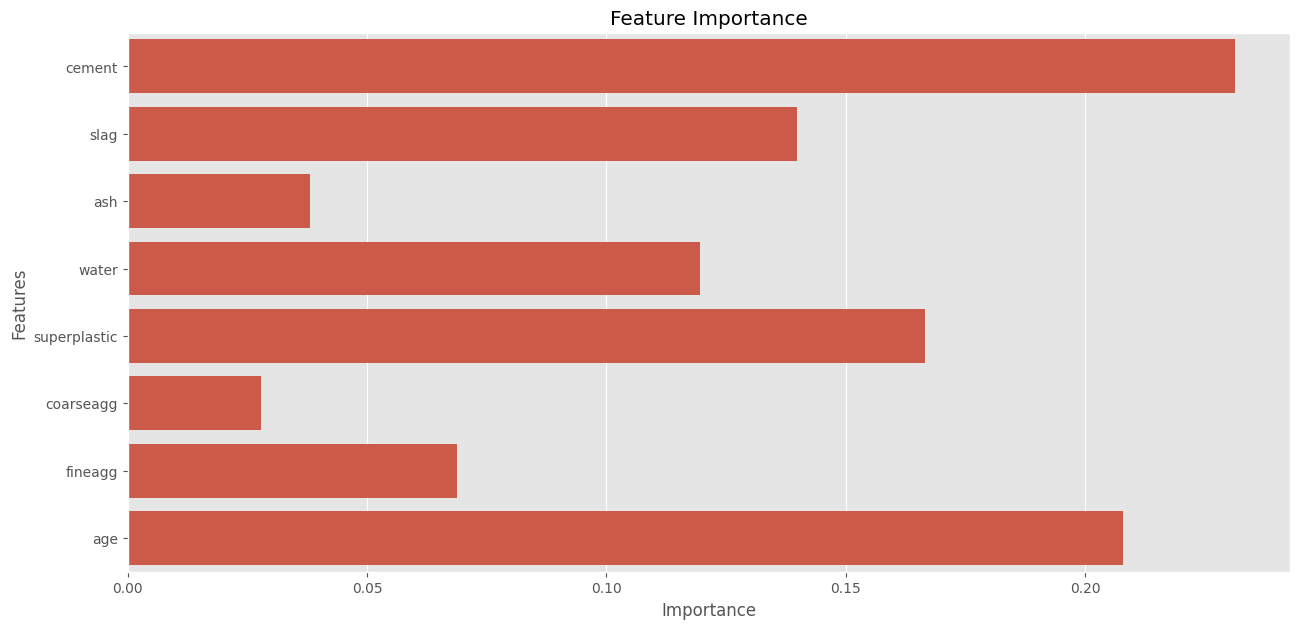

In [20]:
plt.figure(figsize=(15, 7))
plt.title("Feature Importance")
sns.barplot(x=xgb_model.feature_importances_, y=xgb_model.feature_names_in_)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

## KFOLD CROSS-VALIDATION

In [21]:
def CROSS_VALIDATION(X, y, algo, cv=5):
    kfold = KFold(n_splits=cv)
    model_evaluation = []

    for idx, (i, j) in enumerate(kfold.split(X, y)):
        xtrain, xtest = X.iloc[i], X.iloc[j]
        ytrain, ytest = y.iloc[i], y.iloc[j]

        algo.fit(xtrain, ytrain)

        model_evaluation.append([
                                metrics.mean_absolute_error(xgb_model.predict(X_test), y_test),
                                metrics.mean_squared_error(xgb_model.predict(X_test), y_test),
                                np.sqrt(metrics.mean_squared_error(xgb_model.predict(X_test), y_test)),
                                metrics.mean_absolute_percentage_error(xgb_model.predict(X_test), y_test),
                                metrics.r2_score(xgb_model.predict(X_test), y_test)
        ])

    return tabulate.tabulate(model_evaluation,
                             headers=["MAE", "MSE", "RMSE", "MAPE", "R2 SCORE"],
                             tablefmt="rounded_grid", showindex="always")

In [22]:
print(CROSS_VALIDATION(X, y, xgb_model))

╭────┬──────────┬──────────┬─────────┬───────────┬────────────╮
│    │      MAE │      MSE │    RMSE │      MAPE │   R2 SCORE │
├────┼──────────┼──────────┼─────────┼───────────┼────────────┤
│  0 │ 1.22815  │ 17.1198  │ 4.13761 │ 0.0374974 │   0.934279 │
├────┼──────────┼──────────┼─────────┼───────────┼────────────┤
│  1 │ 0.910715 │  3.87771 │ 1.96919 │ 0.0311928 │   0.98579  │
├────┼──────────┼──────────┼─────────┼───────────┼────────────┤
│  2 │ 0.805831 │  3.3125  │ 1.82003 │ 0.0317402 │   0.98783  │
├────┼──────────┼──────────┼─────────┼───────────┼────────────┤
│  3 │ 0.972765 │  3.67131 │ 1.91607 │ 0.035133  │   0.986772 │
├────┼──────────┼──────────┼─────────┼───────────┼────────────┤
│  4 │ 0.93676  │  5.30404 │ 2.30305 │ 0.0319379 │   0.980352 │
╰────┴──────────┴──────────┴─────────┴───────────┴────────────╯


## EXPLORING DIFFERENT ALGORITHMS

1. **GradientBoostingRegressor**
2. **AdaBoostRegressor**
3. **KNeighborsRegressor**
4. **BaggingRegressor**
5. **SVR**
6. **DecisionTreeRegressor**

In [23]:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor



list_of_models = [GradientBoostingRegressor, AdaBoostRegressor, KNeighborsRegressor, BaggingRegressor, SVR, DecisionTreeRegressor]

In [24]:
for algo in list_of_models:
    print(f"Algorithm: {algo.__name__}")
    MODEL = algo()
    print(CROSS_VALIDATION(X, y, MODEL))

Algorithm: GradientBoostingRegressor
╭────┬─────────┬─────────┬─────────┬───────────┬────────────╮
│    │     MAE │     MSE │    RMSE │      MAPE │   R2 SCORE │
├────┼─────────┼─────────┼─────────┼───────────┼────────────┤
│  0 │ 0.93676 │ 5.30404 │ 2.30305 │ 0.0319379 │   0.980352 │
├────┼─────────┼─────────┼─────────┼───────────┼────────────┤
│  1 │ 0.93676 │ 5.30404 │ 2.30305 │ 0.0319379 │   0.980352 │
├────┼─────────┼─────────┼─────────┼───────────┼────────────┤
│  2 │ 0.93676 │ 5.30404 │ 2.30305 │ 0.0319379 │   0.980352 │
├────┼─────────┼─────────┼─────────┼───────────┼────────────┤
│  3 │ 0.93676 │ 5.30404 │ 2.30305 │ 0.0319379 │   0.980352 │
├────┼─────────┼─────────┼─────────┼───────────┼────────────┤
│  4 │ 0.93676 │ 5.30404 │ 2.30305 │ 0.0319379 │   0.980352 │
╰────┴─────────┴─────────┴─────────┴───────────┴────────────╯
Algorithm: AdaBoostRegressor
╭────┬─────────┬─────────┬─────────┬───────────┬────────────╮
│    │     MAE │     MSE │    RMSE │      MAPE │   R2 SCORE │
├───

## PARAMETER OPTIMIZATION

In [37]:
def OPTIMIZER(trials, X, y, cv=5):
    params = {
        "learning_rate": trials.suggest_float("learning_rate", 0.01, 0.1),
        "gamma": trials.suggest_float("gamma", 0, 1),
        "n_estimators":trials.suggest_int("n_estimators", 100, 1000),
        "max_depth": trials.suggest_int("max_depth", 100, 1000),
        "min_child_weight":trials.suggest_int("min_child_weight", 1, 10),
        "subsample":trials.suggest_float("subsample", 0.5, 1),
        "colsample_bytree":trials.suggest_float("colsample_bytree", 0.5, 1)
    }

    kfold = KFold(n_splits=cv)

    xgbr = XGBRegressor(**params)

    rmse = []
    for idx, (i, j) in enumerate(kfold.split(X, y)):
        xtrain, xtest = X.iloc[i], X.iloc[j]
        ytrain, ytest = y.iloc[i], y.iloc[j]

        xgbr.fit(xtrain, ytrain)

        rmse.append(np.sqrt(metrics.mean_squared_error(ytest, xgbr.predict(xtest))))

    return np.mean(rmse)

study = create_study(direction="minimize")

partial_function = partial(OPTIMIZER, X=X, y=y, cv=4)

[I 2024-02-07 20:54:46,749] A new study created in memory with name: no-name-41ddb98f-7860-46aa-919d-08d31ca881d3


In [38]:
study.optimize(partial_function, n_trials=5)

[I 2024-02-07 20:55:03,842] Trial 0 finished with value: 4.559123474653709 and parameters: {'learning_rate': 0.04142829188667712, 'gamma': 0.027392238902157806, 'n_estimators': 350, 'max_depth': 592, 'min_child_weight': 7, 'subsample': 0.8610096763572679, 'colsample_bytree': 0.945885815814431}. Best is trial 0 with value: 4.559123474653709.
[I 2024-02-07 20:55:14,537] Trial 1 finished with value: 4.600549518920825 and parameters: {'learning_rate': 0.04813824151535542, 'gamma': 0.49607026486470296, 'n_estimators': 698, 'max_depth': 430, 'min_child_weight': 8, 'subsample': 0.9579884615335681, 'colsample_bytree': 0.7576878575490205}. Best is trial 0 with value: 4.559123474653709.
[I 2024-02-07 20:55:28,017] Trial 2 finished with value: 4.440177575689902 and parameters: {'learning_rate': 0.05328372894644477, 'gamma': 0.06804384980827116, 'n_estimators': 514, 'max_depth': 590, 'min_child_weight': 8, 'subsample': 0.8319239115974406, 'colsample_bytree': 0.5265483829335198}. Best is trial 2 wi

# Eddy